## Experiments with Word Embeddings

Remember the Synonym Test that we asked you to perform by hand? Well in this project, you will experiment with word embeddings to solve the Synonym test automatically and see if your program does better than you! You will then compare the performance of different models on different data sets and analyse these results to draw insight.

### 1 The Dataset
Download the Synonym Test dataset available on Moodle. This dataset contains 80 English words and 4 choices of synonyms for each word. The task is to select the closest synonym out of these 4 choices.

### 2 Your Tasks
Write a program to use different word embeddings to answer the Synonym Test automatically and compare the performance of different models. You must use:
1. Python 3.11 and the Gensim library. Gensim https://radimrehurek.com/gensim/ is a free open-source Python library for representing documents as vectors. The library allows you to load pre-trained word embeddings, train your own Word2Vec embeddings from your own corpus, computes the similarity of word embeddings, . . .
2. GitHub (make sure your project is private while developing). Your work will be divided into 4 tasks.

#### Task 0: Contribution to a Collective Human Gold-Standard

This task was completed individually on Moodle.

#### Task 1: Evaluation of the word2vec-google-news-300 Pre-trained Model
In this first experiment, you will use the pre-trained Word2Vec model called **word2vec-google-news-300** to compute the closest synonym for each word in the dataset. First, use **gensim.downloader.load** to load the **word2vec-google-news-300** pretrained embedding model. Then use the **similarity** method from **Gensim** to compute the cosine similarity between 2 embeddings (2 vectors) and find the closest synonym to the question-word.

The output of this task should be stored in 2 files:
1. In a file called **(model_name)-details.csv**, for each question in the Synonym Test dataset, in a single line:
  - (a) the question-word, a comma,
  - (b) the correct answer-word, a comma
  - (c) your system’s guess-word, a comma
  - (d) one of 3 possible labels:
    - the label **guess**, if either question-word or all four guess-words (or all 5 words) were not found in the embedding model (so if the question-word was present in the model, and at least 1 guess-word was present also, you should not use this label).
    - the label **correct**, if the question-word and at least 1 guess-word were present in the model, and the guess-word was correct.
    - the label **wrong** if the question-word and at least 1 guess-word were present in the model, and the guess-word was not correct.

2. In a file called **analysis.csv**, in a single line:
  - (a) the model name (clearly indicating the source of the corpus and the vector size), a comma
  - (b) the size of the vocabulary (the number of unique words in the corpus1)
  - (c) the number of **correct** labels (call this C), a comma
  - (d) the number of questions that your model answered without guessing (i.e. 80− guess) (call this V ), a comma
  - (e) the accuracy of the model (i.e. C/V )

*See the assignment pdf for examples of what the output should look like*

In [1]:
# import required libraries
import gensim.downloader as api
import pandas as pd
import matplotlib.pyplot as plt
import random
import csv
import os
import json
from gensim.models import KeyedVectors, Word2Vec
from huggingface_hub import hf_hub_download
import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

In [2]:
# load pre-trained model on word2vec-google-news-300
google_wv = api.load('word2vec-google-news-300')

In [3]:
def computeSimilarity(wv, question, guess):
    '''
    compute the cosine similarity of two given words. Return -1 if word not found
    '''
    try:
        return wv.similarity(question, guess)
    except KeyError:
        return -1

def evaluatePretrainedModel(wv, syn_csv, out_csv):
    '''
        This method takes a pretrained model and uses it to compute the closest synonym in the dataset.
    '''
    # load the synonym file
    synonyms = pd.read_csv(syn_csv)
    labels = []
    guesses = []

    # iterate over every row in the list
    for _, row in synonyms.iterrows():
        try:
            wv[row['question']]
        except KeyError: # pick at random one of the 4 words as system guess, and label 'guess'
            labels.append('guess')
            guesses.append(row[str(random.randint(0, 3))])
            continue
        
        # pass in the question and each of the potential options to the similarity method
        maxSimilarity = -1
        label = 'guess'
        guess = row[str(random.randint(0, 3))]
        for i in range(4):
            cos_sim = computeSimilarity(wv, row['question'], row[str(i)])
            if (cos_sim > maxSimilarity):
                maxSimilarity = cos_sim
                guess = row[str(i)] # store the word that has the highest value as the system guess

        if (maxSimilarity > -1): # label as 'wrong' if not the answer, else 'correct'
            label = 'correct' if guess == row['answer'] else 'wrong'
        # store results
        labels.append(label)
        guesses.append(guess)

    synonyms['guess'] = guesses
    synonyms['label'] = labels
    results = synonyms[['question', 'answer','guess','label']]

    # save the details to csv file in the required format
    results.to_csv(out_csv, header=False, index=False)

    label_counts = results['label'].value_counts()
    print(label_counts)
    C = label_counts['correct']
    V = 80 - label_counts['guess'] if 'guess' in label_counts else 80

    return C, V

In [4]:
# evaluate the synonyms on the pre-trained word2vec-google-news-300 model
C, V = evaluatePretrainedModel(google_wv, 'A2-DataSet/synonym.csv', 'word2vec-google-news-300-details.csv')

# save the model name, size of vocabulary, # of correct labels, # of non-guesses, and the accuracy of model in analysis.csv file
with open('analysis.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['word2vec-google-news-300',len(google_wv.key_to_index),C,V,C/V])

label
correct    70
wrong       9
guess       1
Name: count, dtype: int64


#### Task 2: Comparison with Other Pre-trained Models
Now that you have obtained results with the **word2vec-google-news-300** pre-trained model, you will experiment with 4 other English word2vec pretrained models and compare the results. You can use any pre-trained embeddings that you want, but you must have:
1. 2 new models from different corpora (eg. Twitter, English Wikipedia Dump . . . ) but same embedding size (eg. 25, 100, 300)
2. 2 new models from the same corpus but different embedding sizes

Many pre-trained embeddings are available on line (including in Gensim or at http://vectors.nlpl.eu/repository). For each model that you use, create a new **(model_name)-details.csv** output file and append the results to the file **analysis.csv** (see Section 2.2). *look at the pdf for an example*

Compare the performance of these models (graphs would be very useful here) and compare them to a random baseline and a human gold-standard. Analyse your data points and speculate on why some model perform better than others.

In [5]:
# load 2 new models from different corpora with the same size embeddings
# - note that the professor gave us permission to use Glove embeddings instead of Word2Vec (on Slack)

# Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased) - embedding size 200
glove_twitter_200 = api.load('glove-twitter-200')

In [6]:
# evaluate the synonyms on the pre-trained word2vec-google-news-300 model
C_twit_200, V_twit_200 = evaluatePretrainedModel(glove_twitter_200, 'A2-DataSet/synonym.csv', 'glove-twitter-200-details.csv')

# save the model name, size of vocabulary, # of correct labels, # of non-guesses, and the accuracy of model in analysis.csv file
with open('analysis.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['glove-twitter-200',len(glove_twitter_200.key_to_index),C_twit_200,V_twit_200,C_twit_200/V_twit_200])

label
correct    44
wrong      34
guess       2
Name: count, dtype: int64


In [7]:
# Wikipedia 2014 + Gigaword 5 (6B tokens, uncased) - embedding size: 200
glove_wiki_200 = api.load('glove-wiki-gigaword-200')

In [8]:
# evaluate the synonyms on the pre-trained word2vec-google-news-300 model
C_wiki_200, V_wiki_200 = evaluatePretrainedModel(glove_wiki_200, 'A2-DataSet/synonym.csv', 'glove-wiki-gigaword-200-details.csv')

# save the model name, size of vocabulary, # of correct labels, # of non-guesses, and the accuracy of model in analysis.csv file
with open('analysis.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['glove-wiki-gigaword-200',len(glove_wiki_200.key_to_index),C_wiki_200,V_wiki_200,C_wiki_200/V_wiki_200])

label
correct    68
wrong      12
Name: count, dtype: int64


In [9]:
# load 2 new models from the same corpus but different embedding size

# loaded pretrained Wikipedia embeddings https://huggingface.co/Word2vec/wikipedia2vec_enwiki_20180420_100d
model_wiki_100 = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/wikipedia2vec_enwiki_20180420_100d", filename="enwiki_20180420_100d.txt"))

In [10]:
# evaluate the synonyms on the pre-trained word2vec-google-news-300 model
C_wiki2018_100, V_wiki2018_100 = evaluatePretrainedModel(model_wiki_100, 'A2-DataSet/synonym.csv', 'wikipedia2vec_enwiki_20180420_100d-details.csv')

# save the model name, size of vocabulary, # of correct labels, # of non-guesses, and the accuracy of model in analysis.csv file
with open('analysis.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['wikipedia2vec_enwiki_20180420-100',len(model_wiki_100.key_to_index),C_wiki2018_100,V_wiki2018_100,C_wiki2018_100/V_wiki2018_100])

label
correct    66
wrong      14
Name: count, dtype: int64


In [11]:
# loaded pretrained Wikipedia embeddings https://huggingface.co/Word2vec/wikipedia2vec_enwiki_20180420_300d
model_wiki_300 = KeyedVectors.load_word2vec_format(hf_hub_download(repo_id="Word2vec/wikipedia2vec_enwiki_20180420_300d", filename="enwiki_20180420_300d.txt"))

In [12]:
# evaluate the synonyms on the pre-trained word2vec-google-news-300 model
C_wiki2018_300, V_wiki2018_300 = evaluatePretrainedModel(model_wiki_300, 'A2-DataSet/synonym.csv', 'wikipedia2vec_enwiki_20180420_300d-details.csv')

# save the model name, size of vocabulary, # of correct labels, # of non-guesses, and the accuracy of model in analysis.csv file
with open('analysis.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['wikipedia2vec_enwiki_20180420-300',len(model_wiki_300.key_to_index),C_wiki2018_300,V_wiki2018_300,C_wiki2018_300/V_wiki2018_300])

label
correct    69
wrong      11
Name: count, dtype: int64


In [13]:
# Gold Standard accuracy from the COMP-472-per-question.csv file which contains data collected in task 0 
gold_standard_accuracy = 88.57
random_baseline_accuracy = 25.0 # 1 out of 4 chance

In [14]:
# accuracies for task 2 models
twit_200_accuracy = C_twit_200/V_twit_200
wiki_200_accuracy = C_wiki_200/V_wiki_200
wiki2018_100_accuracy = C_wiki2018_100/V_wiki2018_100
wiki2018_300_accuracy = C_wiki2018_300/V_wiki2018_300

#### Graphing the accuracies

we plot the accuracies to visualise and compare the various models with each other as well as the gold standard and the random baseline

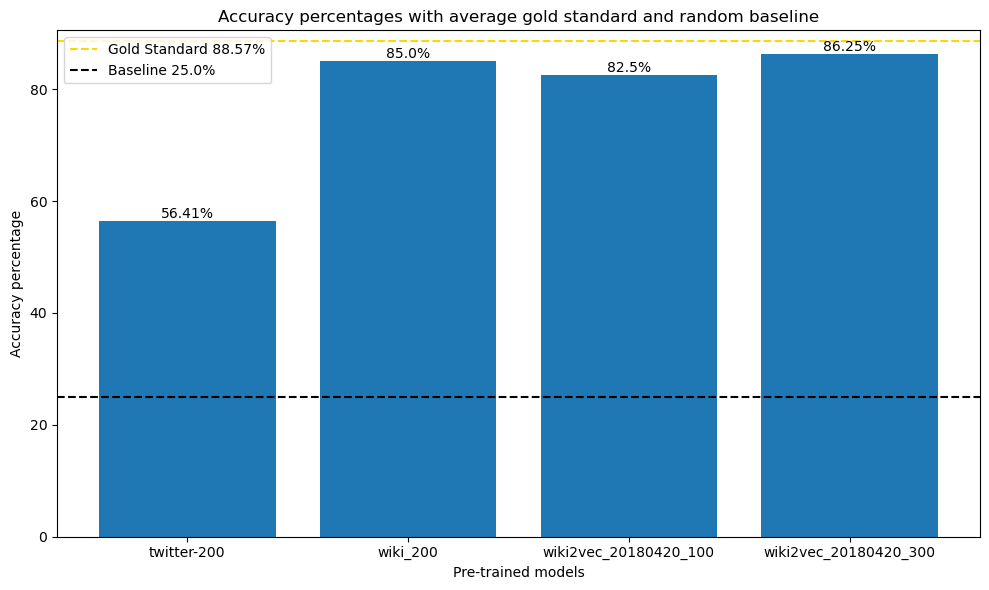

In [15]:
names = ['twitter-200', 'wiki_200', 'wiki2vec_20180420_100', 'wiki2vec_20180420_300']
accuracies = [twit_200_accuracy*100, wiki_200_accuracy*100, wiki2018_100_accuracy*100, wiki2018_300_accuracy*100]

plt.figure(figsize=(10, 6))
bars = plt.bar(names, accuracies) # bars for each of the pre-trained model accuracies

# gold standard and baseline for comparison
plt.axhline(gold_standard_accuracy, color='gold', linestyle='--', label=f'Gold Standard {gold_standard_accuracy}%')
plt.axhline(random_baseline_accuracy, color='black', linestyle='--', label=f'Baseline {random_baseline_accuracy}%')

# accuracy percentage displayed above the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{round(height, 2)}%', ha='center', va='bottom')

# set the titles and labels before displaying
plt.title('Accuracy percentages with average gold standard and random baseline')
plt.xlabel('Pre-trained models')
plt.ylabel('Accuracy percentage')
plt.legend()
plt.tight_layout()

#### Analyze data points 

Here we make a table with all the wrong words in each of the files.

In [16]:
# put all the words that have a wrong label in a list for comparison with the other models
filenames = ['glove-twitter-200-details.csv', 'glove-wiki-gigaword-200-details.csv', 'wikipedia2vec_enwiki_20180420_100d-details.csv', 'wikipedia2vec_enwiki_20180420_300d-details.csv']

details_dfs = [pd.read_csv(filename, header=None) for filename in filenames]
filtered_details = [df[df.iloc[:, -1] == 'wrong'] for df in details_dfs]

# get unique question words for all wrong guesses
unique_question_words = pd.unique(pd.concat([df.iloc[:, 0] for df in filtered_details]))

wrong_words = pd.DataFrame(index=unique_question_words, columns=filenames)

# for each model, save the wrong guesses
for filename, filtered_detail_df in zip(filenames, filtered_details):
    for index, row in filtered_detail_df.iterrows():
        system_guess = row.iloc[2]  # system's guess
        question_word = row.iloc[0]  # question word
        wrong_words.loc[question_word, filename] = system_guess

wrong_words.sort_index(inplace=True) # sort by question words alphabetically
wrong_words.fillna('', inplace=True) # replace NaN values with empty string
wrong_words

,glove-twitter-200-details.csv,glove-wiki-gigaword-200-details.csv,wikipedia2vec_enwiki_20180420_100d-details.csv,wikipedia2vec_enwiki_20180420_300d-details.csv
command,observation,observation,observation,observation
debate,election,,,
deftly,humorously,,,
distribute,commercialize,,,
expeditiously,,,actually,
fashion,craze,,craze,
feasible,equitable,,,
figure,list,list,,
furnish,advise,,advise,advise
generally,accurately,,,


#### Task 3: Train your Own Models
Now, you should be ready to train your own Word2Vec model2. Go to the Project Gutenberg (https://www.gutenberg.org/) and download *at least 5 online books*.
Preprocess these books to generate a list of sentences (i.e. a list of list of words). You may find **nltk3** useful for pre-processing your corpus as it provides a variety of functions to tokenize and split natural language texts (eg. sent tokenize).

Use **Gensim** to create **word2vec** embeddings from your list of sentences. For this, use **gensim.models.Word2Vec**.

Important parameters to pass include:
    **The list of sentences**: use your pre-processed books
    **Window size**: try 2 different values W1 and W2
    **Embedding Size**: try 2 different values E5 and E6

This will therefore lead to 4 new models. By default, **gensim.models.Word2Vec** uses the CBOW method
that we saw in class, so *keep that default value*.

For each model that you use, create a new **(model_name)-details.csv** output file and append the results to the file *analysis.csv* (see Section 2.2). *see the pdf for example*

Compare the performance of these models (graphs would be very useful here). Analyse your data points and speculate on why some model perform better than others.

#### Pre-process the corpus

In [17]:
# download for tokenizaion
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/sephoram/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sephoram/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
# create a set of stopwords
en_stopwords = set(stopwords.words('english'))

def preprocess_sentences(text):
    '''
    Use to tokenize into sentences.
    Removes stopwords, punctuation, and numbers. Lowercase all the words.
    '''
    sentences = sent_tokenize(text)
    return [[word.lower() for word in word_tokenize(sentence) if word.isalpha() and word.lower() not in en_stopwords] for sentence in sentences]

sentences = [] # will store a list of list of words derived from the books

# iterate over the Books directory, extract the content from the books, pre-process the sentences, and store in list
for filename in os.listdir('Books'):
    if filename.endswith('.epub'):
        path = os.path.join('Books', filename)
        book = epub.read_epub(path)

        title = book.get_metadata('DC', 'title') # the epub metadata contains the title info
        if title:
            print(f"Processing '{title[0][0]}'...")
        
        # extract the content from the epub and process as sentences
        content = ''
        for item in book.get_items():
            if item.get_type() == ebooklib.ITEM_DOCUMENT:
                soup = BeautifulSoup(item.content, 'html.parser')
                content += soup.get_text() + '\n'
        
        # Append the text from each epub to the texts list
        text_sentences = preprocess_sentences(content)
        sentences.extend(text_sentences)

len(sentences)

Processing 'A Complete Dictionary of Synonyms and Antonyms / or, Synonyms and Words of Opposite Meaning'...
Processing 'The Devil's Dictionary'...
Processing 'Webster's Unabridged Dictionary'...
Processing 'English Synonyms and Antonyms / With Notes on the Correct Use of Prepositions'...
Processing 'Roget's Thesaurus'...
Processing 'Putnam's Word Book / A Practical Aid in Expressing Ideas Through the Use of an Exact and Varied Vocabulary'...
Processing 'Döderlein's Hand-book of Latin Synonymes'...
Processing 'Roget's Thesaurus of English Words and Phrases'...
Processing 'Modern English biography, volume 2 (of 4), I-Q'...
Processing 'Modern English biography, volume 1 (of 4), A-H'...
Processing 'A Dictionary of English Synonymes and Synonymous or Parallel Expressions / Designed as a Practical Guide to Aptness and Variety of Phraseology'...


1032108

In [19]:
# save sentences in json file --- NOTE: only run this if we want to save newly processed sentences
with open('sentences.json', 'w') as f:
    json.dump(sentences, f)

##### Start from here for task 3 if you have the sentences.json file

In [20]:
# load sentences from json file --- NOTE: only run this if we want to load the processed sentences
with open('sentences.json', 'r') as f:
    sentences = json.load(f)

len(sentences)

1032108

In [21]:
# use Gensim to create word2vec embeddings from the list of sentences
# NOTE: the default min_count is 5 and the majority of the processed books are synonym books or dictionaries, so we reduce the min_count for better performance
'''
From Word2Vec.py for vector_size and window parameters:
vector_size : Dimensionality of the word vectors. (default 100)
window : Maximum distance between the current and predicted word within a sentence. (default 5)
'''

w2v_e5_w1 = Word2Vec(sentences, vector_size=50, window=3, min_count=3)


In [22]:
# evaluate the synonyms on the w2v_e5_w1 model
C_w2v_e5_w1, V_w2v_e5_w1 = evaluatePretrainedModel(w2v_e5_w1.wv, 'A2-DataSet/synonym.csv', 'your_own_corpus-50-3-details.csv')

# save the model name, size of vocabulary, # of correct labels, # of non-guesses, and the accuracy of model in analysis.csv file
with open('analysis.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['your_own_corpus-50-3',len(w2v_e5_w1.wv.key_to_index),C_w2v_e5_w1,V_w2v_e5_w1,C_w2v_e5_w1/V_w2v_e5_w1])

label
correct    51
wrong      25
guess       4
Name: count, dtype: int64


In [23]:
w2v_e5_w2 = Word2Vec(sentences, vector_size=50, window=5, min_count=3)

In [24]:
# evaluate the synonyms on the w2v_e5_w2 model
C_w2v_e5_w2, V_w2v_e5_w2 = evaluatePretrainedModel(w2v_e5_w2.wv, 'A2-DataSet/synonym.csv', 'your_own_corpus-50-5-details.csv')

# save the model name, size of vocabulary, # of correct labels, # of non-guesses, and the accuracy of model in analysis.csv file
with open('analysis.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['your_own_corpus-50-5',len(w2v_e5_w2.wv.key_to_index),C_w2v_e5_w2,V_w2v_e5_w2,C_w2v_e5_w2/V_w2v_e5_w2])

label
correct    52
wrong      24
guess       4
Name: count, dtype: int64


In [25]:
w2v_e6_w1 = Word2Vec(sentences, vector_size=100, window=3, min_count=3)

In [26]:
# evaluate the synonyms on the w2v_e6_w1 model
C_w2v_e6_w1, V_w2v_e6_w1 = evaluatePretrainedModel(w2v_e6_w1.wv, 'A2-DataSet/synonym.csv', 'your_own_corpus-100-3-details.csv')

# save the model name, size of vocabulary, # of correct labels, # of non-guesses, and the accuracy of model in analysis.csv file
with open('analysis.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['your_own_corpus-100-3',len(w2v_e6_w1.wv.key_to_index),C_w2v_e6_w1,V_w2v_e6_w1,C_w2v_e6_w1/V_w2v_e6_w1])

label
correct    47
wrong      29
guess       4
Name: count, dtype: int64


In [27]:
w2v_e6_w2 = Word2Vec(sentences, vector_size=100, window=5, min_count=3)

In [28]:
# evaluate the synonyms on the w2v_e6_w1 model
C_w2v_e6_w2, V_w2v_e6_w2 = evaluatePretrainedModel(w2v_e6_w2.wv, 'A2-DataSet/synonym.csv', 'your_own_corpus-100-5-details.csv')

# save the model name, size of vocabulary, # of correct labels, # of non-guesses, and the accuracy of model in analysis.csv file
with open('analysis.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['your_own_corpus-100-5',len(w2v_e6_w2.wv.key_to_index),C_w2v_e6_w2,V_w2v_e6_w2,C_w2v_e6_w2/V_w2v_e6_w2])

label
correct    49
wrong      27
guess       4
Name: count, dtype: int64


#### Graphing the accuracies

we plot the accuracies to visualise and compare the various models with each other as well as the gold standard and the random baseline

In [29]:
w2v_e5_w1_accuracy = C_w2v_e5_w1/V_w2v_e5_w1
w2v_e5_w2_accuracy = C_w2v_e5_w2/V_w2v_e5_w2
w2v_e6_w1_accuracy = C_w2v_e6_w1/V_w2v_e6_w1
w2v_e6_w2_accuracy = C_w2v_e6_w2/V_w2v_e6_w2

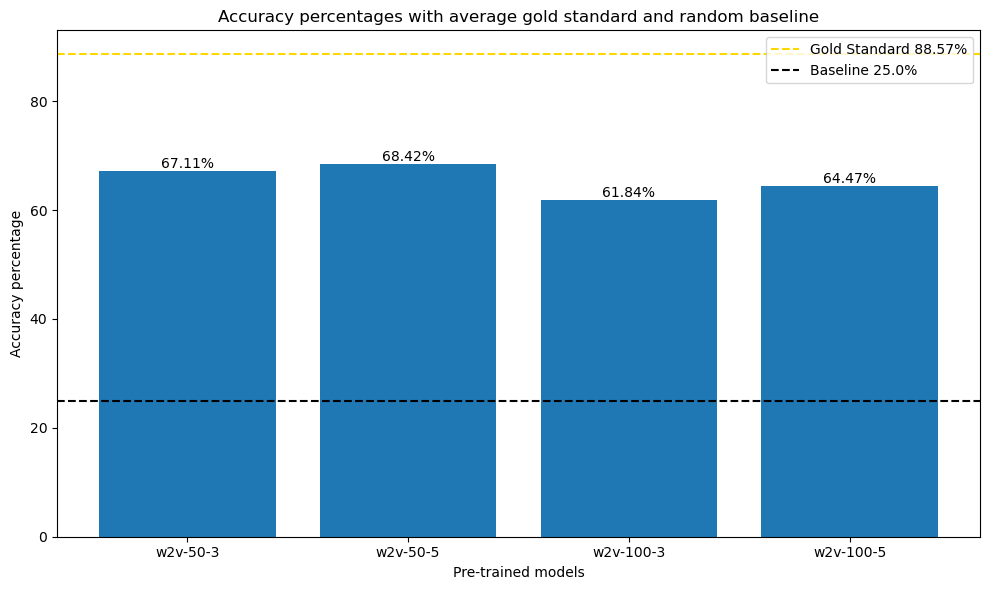

In [30]:
names = ['w2v-50-3', 'w2v-50-5', 'w2v-100-3', 'w2v-100-5']
accuracies = [w2v_e5_w1_accuracy*100, w2v_e5_w2_accuracy*100, w2v_e6_w1_accuracy*100, w2v_e6_w2_accuracy*100]

plt.figure(figsize=(10, 6))
bars = plt.bar(names, accuracies) # bars for each of the pre-trained model accuracies

# gold standard and baseline for comparison
plt.axhline(gold_standard_accuracy, color='gold', linestyle='--', label=f'Gold Standard {gold_standard_accuracy}%')
plt.axhline(random_baseline_accuracy, color='black', linestyle='--', label=f'Baseline {random_baseline_accuracy}%')

# accuracy percentage displayed above the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{round(height, 2)}%', ha='center', va='bottom')

# set the titles and labels before displaying
plt.title('Accuracy percentages with average gold standard and random baseline')
plt.xlabel('Pre-trained models')
plt.ylabel('Accuracy percentage')
plt.legend()
plt.tight_layout()

#### Analyze data points 

Here we make a table with all the wrong words in each of the files.

In [31]:
# put all the words that have a wrong label in a list for comparison with the other models
filenames = ['your_own_corpus-50-3-details.csv', 'your_own_corpus-50-5-details.csv', 'your_own_corpus-100-3-details.csv', 'your_own_corpus-100-5-details.csv']

details_dfs = [pd.read_csv(filename, header=None) for filename in filenames]
filtered_details = [df[df.iloc[:, -1] == 'wrong'] for df in details_dfs]

# get unique question words for all wrong guesses
unique_question_words = pd.unique(pd.concat([df.iloc[:, 0] for df in filtered_details]))

wrong_words = pd.DataFrame(index=unique_question_words, columns=filenames)

# for each model, save the wrong guesses
for filename, filtered_detail_df in zip(filenames, filtered_details):
    for index, row in filtered_detail_df.iterrows():
        system_guess = row.iloc[2]  # system's guess
        question_word = row.iloc[0]  # question word
        wrong_words.loc[question_word, filename] = system_guess

wrong_words.sort_index(inplace=True) # sort by question words alphabetically
wrong_words.fillna('', inplace=True) # replace NaN values with empty string
wrong_words

,your_own_corpus-50-3-details.csv,your_own_corpus-50-5-details.csv,your_own_corpus-100-3-details.csv,your_own_corpus-100-5-details.csv
arranged,,,explained,explained
bigger,closer,closer,closer,closer
colloquial,misunderstood,,misunderstood,
concisely,powerfully,powerfully,powerfully,powerfully
concocted,supervised,cleaned,supervised,cleaned
consumed,supplied,caught,caught,supplied
deftly,prudently,,prudently,
enormously,decidedly,decidedly,decidedly,decidedly
essentially,ordinarily,ordinarily,ordinarily,ordinarily
expeditiously,repeatedly,repeatedly,repeatedly,repeatedly
